##### https://www.kaggle.com/datasets/mirichoi0218/insurance

*   The dataset has 7 columns (6 predictors), so the condition n ≥ p + 5 becomes n ≥ 6 + 5, which simplifies to n ≥ 11. Since the dataset has 1338 rows, which is greater than 11, it satisfies this condition.
*   The Medical Cost Personal Datasets on Kaggle has several columns. The **quantitative** columns are `age`, `bmi`, `children`, and `charges`. The **categorical** columns are `sex`, `smoker`, and `region`.

#### Import the used libraries


In [ ]:
from pandas.plotting import scatter_matrix
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# python -m pip install statsmodels
# pip install -U scikit-learn

In [ ]:
from google.colab import files
import io

# Upload the CSV file from your local computer
uploaded = files.upload()

# Load only the first 7 columns of the uploaded CSV file into a pandas DataFrame
df = pd.read_csv(io.StringIO(uploaded[list(uploaded.keys())[0]].decode('utf-8')), usecols=range(7))

Saving insurance.csv to insurance.csv


In [ ]:
# Define a function to calculate the z-score of a given series by subtracting the mean from each value and dividing the result by the standard deviation.
def z_score(series):
    return (series - series.mean()) / series.std()

# Calculate the Z-score for each numeric column
z_scores = df.select_dtypes(include='number').apply(z_score)

# Define a threshold for identifying outliers
threshold = 3

# Identify outliers in each column
outliers = (z_scores.abs() > threshold).any(axis=1)

# Remove outliers from the DataFrame
df_clean = df[~outliers]

# View the first few rows of the cleaned DataFrame
df_clean.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
#Find themin, 25%, 50%, 75%, and max.
stats = df_clean.describe()

# Print the results
print(stats)

               age          bmi     children       charges
count  1309.000000  1309.000000  1309.000000   1309.000000
mean     39.262032    30.584037     1.045073  13089.622269
std      14.085397     5.975320     1.124627  11738.168486
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.315000     0.000000   4686.388700
50%      39.000000    30.305000     1.000000   9377.904700
75%      51.000000    34.580000     2.000000  16577.779500
max      64.000000    48.070000     4.000000  49577.662400


In [ ]:
#The interquartile range (IQR)
q1 = df_clean.quantile(0.25)
q3 = df_clean.quantile(0.75)

# Calculate the interquartile range for each numeric column
iqr = q3 - q1
# Print the results
print(iqr)

age            24.0000
bmi             8.2650
children        2.0000
charges     11891.3908
dtype: float64


<ipython-input-5-08748f077186>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q1 = df_clean.quantile(0.25)
<ipython-input-5-08748f077186>:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q3 = df_clean.quantile(0.75)


In [ ]:
# Create a copy of df_clean and store it in df_clean_standardized
df_clean_standardized = df_clean.copy()

# Calculate z-scores for numerical columns in df_clean_standardized
z_scores = df_clean_standardized.select_dtypes(include='number').apply(z_score)

# Replace numerical columns in df_clean_standardized with their z-scores
df_clean_standardized[z_scores.columns] = z_scores

# View the first few rows of df_clean_standardized
df_clean_standardized.head()

,age,sex,bmi,children,smoker,region,charges
0,-1.438513,female,-0.449187,-0.929261,yes,southwest,0.323330
1,-1.509509,male,0.533187,-0.040078,no,southeast,-0.968130
2,-0.799554,male,0.404324,1.738289,no,southeast,-0.736074
3,-0.444576,male,-1.318597,-0.929261,no,northwest,0.757771
4,-0.515572,male,-0.285179,-0.929261,no,northwest,-0.785708


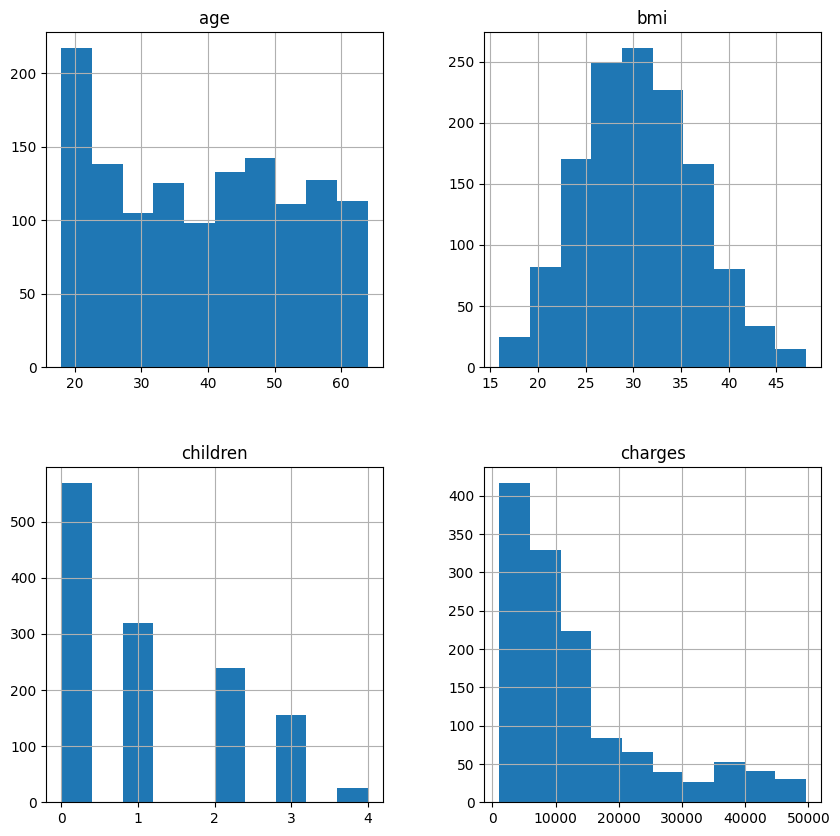

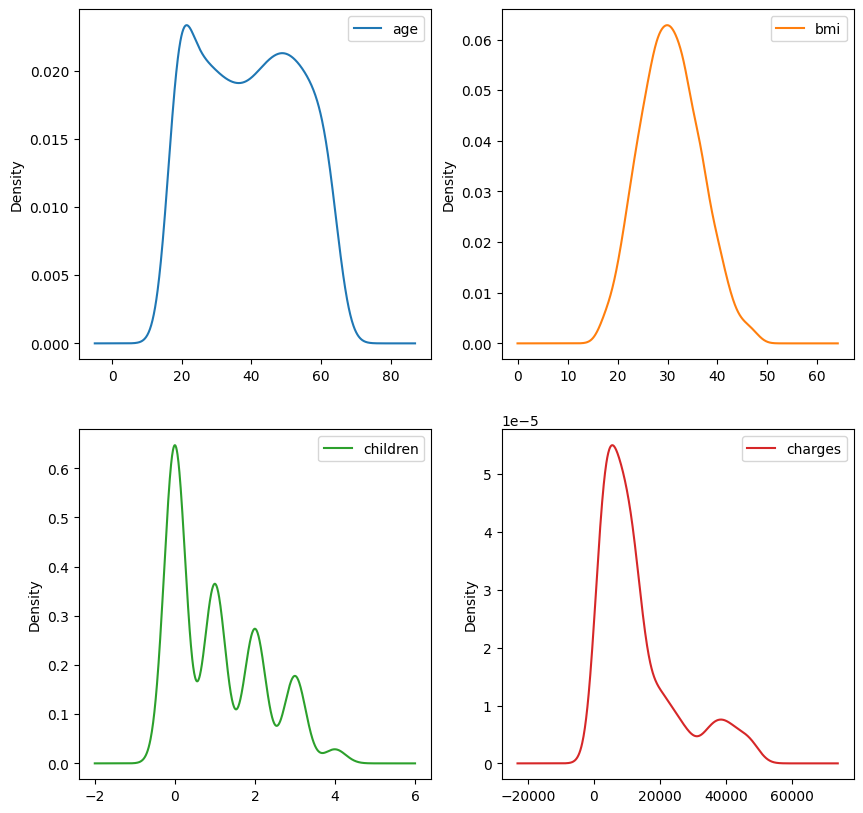

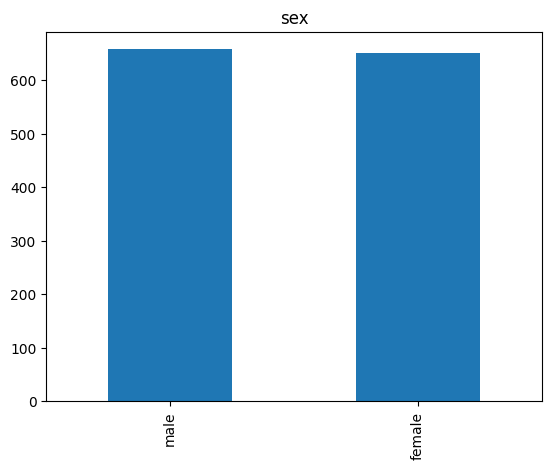

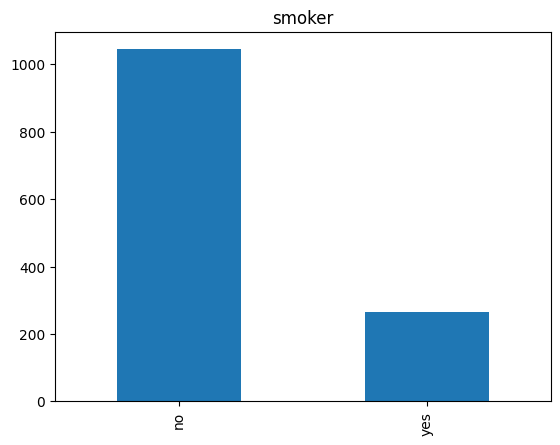

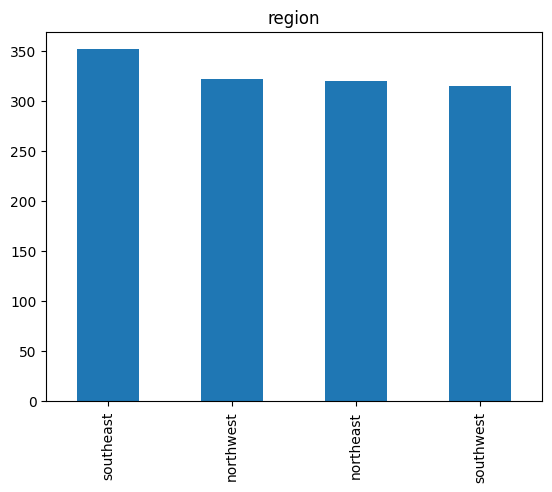

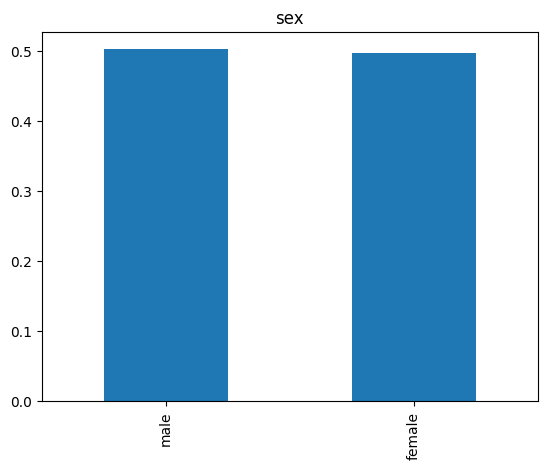

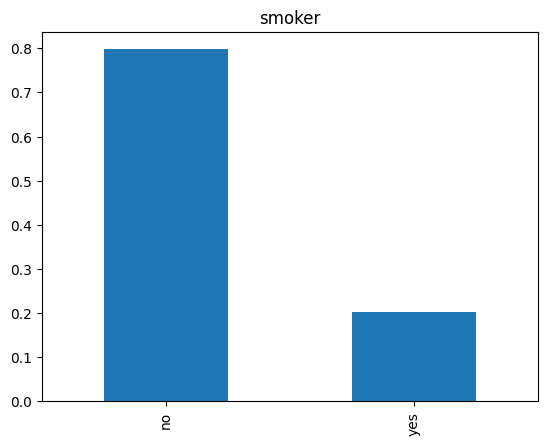

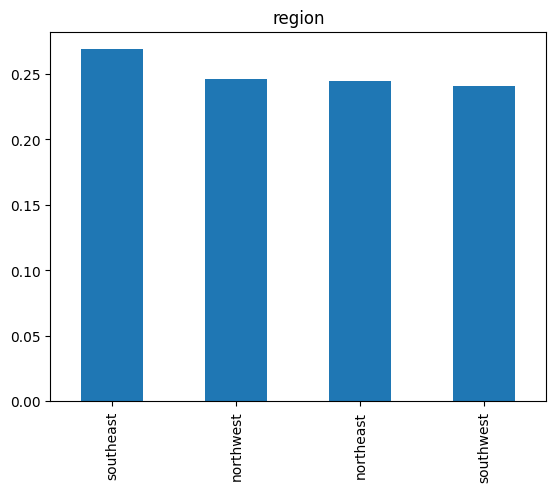

In [ ]:
import matplotlib.pyplot as plt

# Create histograms of all columns in df_clean
df_clean.hist(figsize=(10, 10))

# Create kernel density plots of all columns in df_clean
df_clean.plot(kind='kde', subplots=True, layout=(2, 2), figsize=(10, 10), sharex=False)

# Select only the categorical columns
categorical_columns = df.select_dtypes(include='object').columns

# Create bar plots of the value counts for each categorical column in df_clean
for col in categorical_columns:
    plt.figure()
    df_clean[col].value_counts().plot.bar(title=col)

# Create bar plots of the relative frequencies for each categorical column in df_clean
for col in categorical_columns:
    plt.figure()
    (df_clean[col].value_counts() / len(df_clean)).plot.bar(title=col)
plt.show()

##### A Gaussian distribution has a characteristic bell shape with a single peak in the middle. The data is symmetrically distributed around the mean, with most of the data concentrated near the mean and fewer data points further away from the mean. The tails of the distribution extend infinitely in both directions and approach zero asymptotically.

##### An exponential distribution has a characteristic J shape with a peak at the left end and a long tail that extends to the right. The data is skewed to the right, with most of the data concentrated near the left end and fewer data points further away from the left end. The tail of the distribution extends infinitely to the right and approaches zero asymptotically.

##### A uniform distribution has a characteristic rectangular shape with a constant height over its entire range. The data is evenly distributed over a fixed interval, with all values within this interval having an equal probability of occurring.

## Normal distribution test

In [ ]:
from scipy.stats import shapiro

# Extract the 'age' column from the DataFrame
data = df_clean['age']

# Perform the Shapiro-Wilk test on the data
stat, p = shapiro(data)

# Print the results
print(f'Statistic: {stat:.4f}, p-value: {p:.4f}')

# Interpret the results
alpha = 0.05
if p > alpha:
    print('age follows a Gaussian distribution (fail to reject H0)')
    print()
else:
    print('age does not follow a Gaussian distribution (reject H0)')
    print()

# Extract the 'bmi' column from the DataFrame
data = df_clean['bmi']

# Perform the Shapiro-Wilk test on the data
stat, p = shapiro(data)

# Print the results
print(f'Statistic: {stat:.4f}, p-value: {p:.4f}')

# Interpret the results
alpha = 0.05
if p > alpha:
    print('bmi follows a Gaussian distribution (fail to reject H0)')
    print()
else:
    print('bmi does not follow a Gaussian distribution (reject H0)')
    print()

# Extract the 'children' column from the DataFrame
data = df_clean['children']

# Perform the Shapiro-Wilk test on the data
stat, p = shapiro(data)

# Print the results
print(f'Statistic: {stat:.4f}, p-value: {p:.4f}')

# Interpret the results
alpha = 0.05
if p > alpha:
    print('children follows a Gaussian distribution (fail to reject H0)')
    print()
else:
    print('children does not follow a Gaussian distribution (reject H0)')
    print()

# Extract the 'charges' column from the DataFrame
data = df_clean['charges']

# Perform the Shapiro-Wilk test on the data
stat, p = shapiro(data)

# Print the results
print(f'Statistic: {stat:.4f}, p-value: {p:.4f}')

# Interpret the results
alpha = 0.05
if p > alpha:
    print('charges follows a Gaussian distribution (fail to reject H0)')
    print()
else:
    print('charges does not follow a Gaussian distribution (reject H0)')
    print()

Statistic: 0.9442, p-value: 0.0000
age does not follow a Gaussian distribution (reject H0)

Statistic: 0.9951, p-value: 0.0003
bmi does not follow a Gaussian distribution (reject H0)

Statistic: 0.8217, p-value: 0.0000
children does not follow a Gaussian distribution (reject H0)

Statistic: 0.8195, p-value: 0.0000
charges does not follow a Gaussian distribution (reject H0)



*   Null hypothesis (H0): The data comes from a normal distribution.
*   Alternative hypothesis (Ha): The data does not come from a normal distribution.

## Exponential distribution test

In [ ]:
from scipy.stats import anderson

# Extract the 'age' column from the DataFrame
data = df_clean['age']

# Perform the Anderson-Darling test on the data
result = anderson(data, dist='expon')

# Print the results
print(f'Statistic: {result.statistic:.4f}')
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print(f'{sl:.2f}: {cv:.4f}, age follows an exponential distribution (fail to reject H0)')
    else:
        print(f'{sl:.2f}: {cv:.4f}, age does not follow an exponential distribution (reject H0)')
print()

# Extract the 'bmi' column from the DataFrame
data = df_clean['bmi']

# Perform the Anderson-Darling test on the data
result = anderson(data, dist='expon')

# Print the results
print(f'Statistic: {result.statistic:.4f}')
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print(f'{sl:.2f}: {cv:.4f}, bmi follows an exponential distribution (fail to reject H0)')
    else:
        print(f'{sl:.2f}: {cv:.4f}, bmi does not follow an exponential distribution (reject H0)')
print()

# Extract the 'children' column from the DataFrame
data = df_clean['children']

# Perform the Anderson-Darling test on the data
result = anderson(data, dist='expon')

# Print the results
print(f'Statistic: {result.statistic:.4f}')
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print(f'{sl:.2f}: {cv:.4f}, children follows an exponential distribution (fail to reject H0)')
    else:
        print(f'{sl:.2f}: {cv:.4f}, children does not follow an exponential distribution (reject H0)')
print()

# Extract the 'charges' column from the DataFrame
data = df_clean['charges']

# Perform the Anderson-Darling test on the data
result = anderson(data, dist='expon')

# Print the results
print(f'Statistic: {result.statistic:.4f}')
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < cv:
        print(f'{sl:.2f}: {cv:.4f}, charges follows an exponential distribution (fail to reject H0)')
    else:
        print(f'{sl:.2f}: {cv:.4f}, charges does not follow an exponential distribution (reject H0)')
print()

Statistic: 237.8169
15.00: 0.9220, age does not follow an exponential distribution (reject H0)
10.00: 1.0780, age does not follow an exponential distribution (reject H0)
5.00: 1.3400, age does not follow an exponential distribution (reject H0)
2.50: 1.6050, age does not follow an exponential distribution (reject H0)
1.00: 1.9560, age does not follow an exponential distribution (reject H0)

Statistic: 391.4204
15.00: 0.9220, bmi does not follow an exponential distribution (reject H0)
10.00: 1.0780, bmi does not follow an exponential distribution (reject H0)
5.00: 1.3400, bmi does not follow an exponential distribution (reject H0)
2.50: 1.6050, bmi does not follow an exponential distribution (reject H0)
1.00: 1.9560, bmi does not follow an exponential distribution (reject H0)

Statistic: inf
15.00: 0.9220, children does not follow an exponential distribution (reject H0)
10.00: 1.0780, children does not follow an exponential distribution (reject H0)
5.00: 1.3400, children does not follow 

## Uniform distribution test

In [ ]:
from scipy import stats

# Extract the 'age' column from the DataFrame
data = df_clean['age']

# Perform the Kolmogorov-Smirnov test on the data
stat, p = stats.kstest(data, 'uniform')

# Print the results
print(f'Statistic: {stat:.4f}, p-value: {p:.4f}')

# Interpret the results
alpha = 0.05
if p > alpha:
    print('age follows a uniform distribution (fail to reject H0)')
    print()
else:
    print('age does not follow a uniform distribution (reject H0)')
    print()

# Extract the 'bmi' column from the DataFrame
data = df_clean['bmi']

# Perform the Kolmogorov-Smirnov test on the data
stat, p = stats.kstest(data, 'uniform')

# Print the results
print(f'Statistic: {stat:.4f}, p-value: {p:.4f}')

# Interpret the results
alpha = 0.05
if p > alpha:
    print('bmi follows a uniform distribution (fail to reject H0)')
    print()
else:
    print('bmi does not follow a uniform distribution (reject H0)')
    print()

# Extract the 'children' column from the DataFrame
data = df_clean['children']

# Perform the Kolmogorov-Smirnov test on the data
stat, p = stats.kstest(data, 'uniform')

# Print the results
print(f'Statistic: {stat:.4f}, p-value: {p:.4f}')

# Interpret the results
alpha = 0.05
if p > alpha:
    print('children follows a uniform distribution (fail to reject H0)')
    print()
else:
    print('children does not follow a uniform distribution (reject H0)')
    print()

# Extract the 'charges' column from the DataFrame
data = df_clean['charges']

# Perform the Kolmogorov-Smirnov test on the data
stat, p = stats.kstest(data, 'uniform')

# Print the results
print(f'Statistic: {stat:.4f}, p-value: {p:.4f}')

# Interpret the results
alpha = 0.05
if p > alpha:
    print('charges follows a uniform distribution (fail to reject H0)')
    print()
else:
    print('charges does not follow a uniform distribution (reject H0)')
    print()

Statistic: 1.0000, p-value: 0.0000
age does not follow a uniform distribution (reject H0)

Statistic: 1.0000, p-value: 0.0000
bmi does not follow a uniform distribution (reject H0)

Statistic: 0.5661, p-value: 0.0000
children does not follow a uniform distribution (reject H0)

Statistic: 1.0000, p-value: 0.0000
charges does not follow a uniform distribution (reject H0)



#### Categorical columns cannot be normally, exponentially or uniformly distributed. Normal, exponential and uniform distributions are continuous probability distributions that describe the distribution of continuous random variables. Categorical data, on the other hand, is discrete and can take on only a finite number of distinct values. Therefore, it is not meaningful to describe the distribution of categorical data using continuous probability distributions.

In [ ]:
# One-hot encode categorical variables
data_encoded = pd.get_dummies(df_clean)

# Compute the correlation matrix
corr_matrix = data_encoded.corr()

# Get the correlation coefficients for the response variable
response_variable = 'charges'
correlations = corr_matrix[response_variable]

# Print the correlations
print(correlations)

age                 0.305263
bmi                 0.191453
children            0.100438
charges             1.000000
sex_female         -0.059455
sex_male            0.059455
smoker_no          -0.785129
smoker_yes          0.785129
region_northeast    0.011435
region_northwest   -0.045847
region_southeast    0.074829
region_southwest   -0.042922
Name: charges, dtype: float64


# Multiple simple linear regression

### As for categorical variables, region (northeast, northwest, southeast, southwest), sex (male, female), smoker (yes, no)
### They need special treatment, they should be transformed to dummy variables / one hot vectors at first

In [ ]:
def simple_linear_regression(x,y):
  n=len(x)

  # Calculate means
  x_mean = sum(x) / n
  y_mean = sum(y) / n

  # Calculate variances
  x_var = sum((xi - x_mean) ** 2 for xi in x)
  xy_cov = sum((xi - x_mean) * (yi - y_mean) for xi, yi in zip(x, y))

  # Calculate regression coefficients
  slope = xy_cov / x_var
  intercept = y_mean - slope * x_mean

  return slope, intercept

y = df_clean['charges']

# Calculate regression coefficients for BMI
x_bmi = df_clean['bmi']
slope_bmi, intercept_bmi = simple_linear_regression(x_bmi, y)
print(f"Regression Coefficient for feature bmi: {slope_bmi} and Intercept: {intercept_bmi}")

# Calculate regression coefficients for children
x_children = df_clean['children']
slope_children, intercept_children = simple_linear_regression(x_children, y)
print(f"Regression Coefficient for feature children: {slope_children} and Intercept: {intercept_children}")

# Calculate regression coefficients for age
x_age = df_clean['age']
slope_age, intercept_age = simple_linear_regression(x_age, y)
print(f"Regression Coefficient for feature age: {slope_age} and Intercept: {intercept_age}")

# Calculate regression coefficients for sex
x_sex_male = pd.get_dummies(df_clean['sex'])['male']
slope_sex_male, intercept_sex_male = simple_linear_regression(x_sex_male, y)
print(f"Regression Coefficient for feature sex (male): {slope_sex_male} and Intercept: {intercept_sex_male}")

x_sex_female = pd.get_dummies(df_clean['sex'])['female']
slope_sex_female, intercept_sex_female = simple_linear_regression(x_sex_female, y)
print(f"Regression Coefficient for feature sex (female): {slope_sex_female} and Intercept: {intercept_sex_female}")

# Calculate regression coefficients for region
x_region_northeast = pd.get_dummies(df_clean['region'])['northeast']
slope_region_northeast, intercept_region_northeast = simple_linear_regression(x_region_northeast, y)
print(f"Regression Coefficient for feature region (northeast): {slope_region_northeast} and Intercept: {intercept_region_northeast}")

x_region_northwest = pd.get_dummies(df_clean['region'])['northwest']
slope_region_northwest, intercept_region_northwest = simple_linear_regression(x_region_northwest, y)
print(f"Regression Coefficient for feature region (northwest): {slope_region_northwest} and Intercept: {intercept_region_northwest}")

x_region_southeast = pd.get_dummies(df_clean['region'])['southeast']
slope_region_southeast, intercept_region_southeast = simple_linear_regression(x_region_southeast, y)
print(f"Regression Coefficient for feature region (southeast): {slope_region_southeast} and Intercept: {intercept_region_southeast}")

x_region_southwest = pd.get_dummies(df_clean['region'])['southwest']
slope_region_southwest, intercept_region_southwest = simple_linear_regression(x_region_southwest, y)
print(f"Regression Coefficient for feature region (southwest): {slope_region_southwest} and Intercept: {intercept_region_southwest}")

# Calculate regression coefficients for smoker
x_smoker_yes = pd.get_dummies(df_clean['smoker'])['yes']
slope_smoker_yes, intercept_smoker_yes = simple_linear_regression(x_smoker_yes, y)
print(f"Regression Coefficient for feature smoker (yes): {slope_smoker_yes} and Intercept: {intercept_smoker_yes}")

x_smoker_no = pd.get_dummies(df_clean['smoker'])['no']
slope_smoker_no, intercept_smoker_no = simple_linear_regression(x_smoker_no, y)
print(f"Regression Coefficient for feature smoker (no): {slope_smoker_no} and Intercept: {intercept_smoker_no}")


Regression Coefficient for feature bmi: 376.0980711938653 and Intercept: 1587.0247807011838
Regression Coefficient for feature children: 1048.3078130409544 and Intercept: 11994.064523605019
Regression Coefficient for feature age: 254.39323404062714 and Intercept: 3101.6269513789175
Regression Coefficient for feature sex (male): 1395.2785809324955 and Intercept: 12388.25228677266
Regression Coefficient for feature sex (female): -1395.2785809324955 and Intercept: 13783.530867705156
Regression Coefficient for feature region (northeast): 312.2005633962111 and Intercept: 13013.301275288164
Regression Coefficient for feature region (northwest): -1249.0924966715677 and Intercept: 13396.885663534942
Regression Coefficient for feature region (southeast): 1980.2345027727877 and Intercept: 12557.122234272707
Regression Coefficient for feature region (southwest): -1178.1669927772004 and Intercept: 13373.138389888321
Regression Coefficient for feature smoker (yes): 22926.72098620297 and Intercept: 

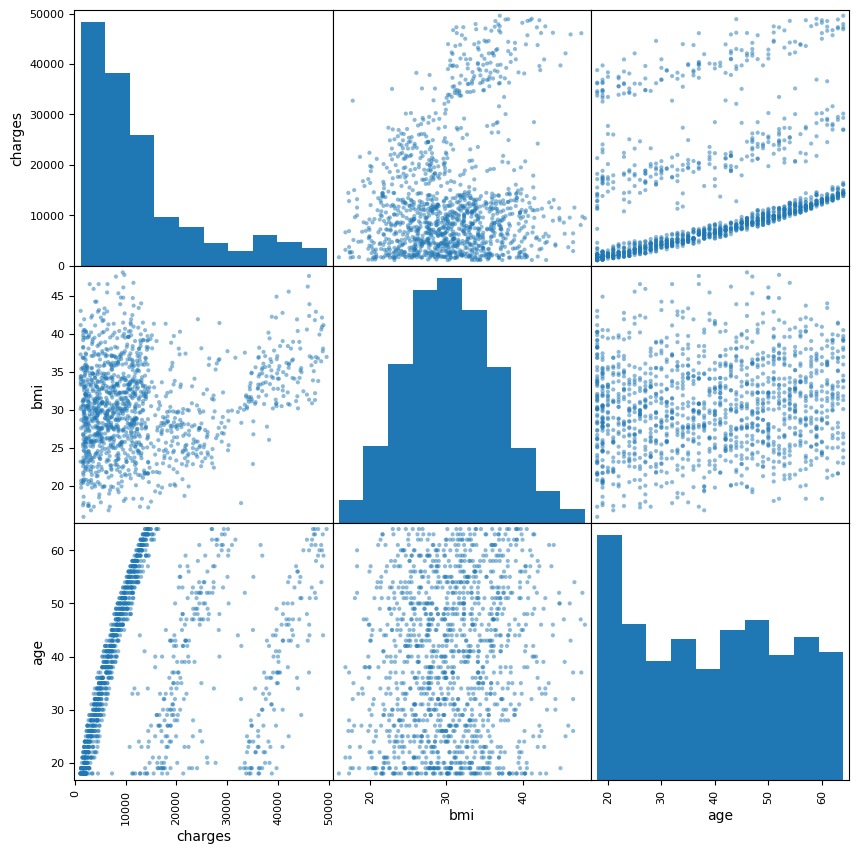

In [ ]:
# Select the columns for the scatter matrix
selected_columns = ['charges', 'bmi', 'age']

# Subset the DataFrame with the selected columns
df_selected = df_clean[selected_columns]

# Create the scatter matrix
scatter_matrix(df_selected, figsize=(10, 10), diagonal='hist')

# Show the scatter matrix
plt.show()


## Regression Coefficient (RC) of Each Individual Variable Using Python Standard Library

In [ ]:

# Response variable
y = df_clean['charges']

# Numerical features
numerical_features = ['age', 'bmi', 'children']

# Categorical features
categorical_features = ['smoker', 'region', 'sex']

# Fit simple linear regression models for each numerical feature
coefficients = {}
intercepts = {}

for feature in numerical_features:
    # Remove missing values from the feature
    x = df_clean[feature]

    # Add a constant term to the predictor variable
    x = sm.add_constant(x)

    # Fit a simple linear regression model using statsmodels
    model = sm.OLS(y, x).fit()

    # Get the intercept and slope coefficients from the statsmodels model
    intercept, slope = model.params

    print(f"Regression Coefficient for feature {feature}: {slope} and Intercept: {intercept}")




x_smoker_yes_sm = pd.get_dummies(df_clean['smoker'])['yes']
x_region_southwest_sm = pd.get_dummies(df_clean['region'])['southwest']
x_region_southeast_sm = pd.get_dummies(df_clean['region'])['southeast']
x_region_northwest_sm = pd.get_dummies(df_clean['region'])['northwest']
x_region_northeast_sm = pd.get_dummies(df_clean['region'])['northeast']
x_sex_female_sm = pd.get_dummies(df_clean['sex'])['female']
x_sex_male_sm = pd.get_dummies(df_clean['sex'])['male']




Regression Coefficient for feature age: 254.39323404062705 and Intercept: 3101.626951378923
Regression Coefficient for feature bmi: 376.0980711938663 and Intercept: 1587.024780701156
Regression Coefficient for feature children: 1048.3078130409694 and Intercept: 11994.06452360501


In [ ]:
# Categorical features
x_smoker_no_sm = pd.get_dummies(df_clean['smoker'])['no']
x_smoker_yes_sm = pd.get_dummies(df_clean['smoker'])['yes']
x_region_southwest_sm = pd.get_dummies(df_clean['region'])['southwest']
x_region_southeast_sm = pd.get_dummies(df_clean['region'])['southeast']
x_region_northwest_sm = pd.get_dummies(df_clean['region'])['northwest']
x_region_northeast_sm = pd.get_dummies(df_clean['region'])['northeast']
x_sex_female_sm = pd.get_dummies(df_clean['sex'])['female']
x_sex_male_sm = pd.get_dummies(df_clean['sex'])['male']

# Fit linear regression models for each categorical feature
categorical_features = {
    'smoker (no)': x_smoker_no_sm ,
    'smoker (yes)': x_smoker_yes_sm,
    'region (southwest)': x_region_southwest_sm,
    'region (southeast)': x_region_southeast_sm,
    'region (northwest)': x_region_northwest_sm,
    'region (northeast)': x_region_northeast_sm,
    'sex (female)': x_sex_female_sm,
    'sex (male)': x_sex_male_sm
}

for feature, x_categorical in categorical_features.items():
    x = pd.DataFrame(x_categorical)
    x = x.astype(float)
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    intercept, slope = model.params
    print(f"Regression Coefficient for feature {feature}: {slope} and Intercept: {intercept}")


Regression Coefficient for feature smoker (no): -22926.72098620291 and Intercept: 31374.952069698207
Regression Coefficient for feature smoker (yes): 22926.720986202923 and Intercept: 8448.231083495208
Regression Coefficient for feature region (southwest): -1178.1669927772182 and Intercept: 13373.138389888325
Regression Coefficient for feature region (southeast): 1980.2345027727297 and Intercept: 12557.122234272723
Regression Coefficient for feature region (northwest): -1249.0924966715972 and Intercept: 13396.885663534944
Regression Coefficient for feature region (northeast): 312.20056339620396 and Intercept: 13013.301275288179
Regression Coefficient for feature sex (female): -1395.2785809325146 and Intercept: 13783.530867705183
Regression Coefficient for feature sex (male): 1395.2785809325137 and Intercept: 12388.252286772666


# Multiple Linear Regression

In [ ]:
import numpy as np

# Create a Linear Regression model object
model_multiple_regression = LinearRegression()

# Select the predictor variables (features) and the response variable
X = data_encoded.drop('charges', axis=1)
y = data_encoded['charges']

# Fit the model to the training data
model_multiple_regression.fit(X, y)

# Interpret the regression coefficients and the intercept
print("Multiple Regression")
for i, col in enumerate(X.columns):
    print(f"Predictor: {col}")
    print(f"Coefficient: {model_multiple_regression.coef_[i]}")
print(f"the model intercept {model_multiple_regression.intercept_}")

# Calculate R-squared
R_squared = model_multiple_regression.score(X, y)
print(f"R-squared: {R_squared}")

# Calculate RMSE
y_pred = model_multiple_regression.predict(X)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Square Error (RMSE): {rmse}")
# calculate adjusted R-squared
n = df_clean.shape[0]
p = 6
adjusted_R_squared = 1 - ((1 - R_squared) * (n - 1) / (n - p - 1))
print (f"adjusted_R_squared: {adjusted_R_squared}")


Multiple Regression
Predictor: age
Coefficient: 254.47936690001617
Predictor: bmi
Coefficient: 325.48677847744955
Predictor: children
Coefficient: 567.5448838445229
Predictor: sex_female
Coefficient: 59.01019502288478
Predictor: sex_male
Coefficient: -59.01019502288364
Predictor: smoker_no
Coefficient: -11597.956173555196
Predictor: smoker_yes
Coefficient: 11597.956173555198
Predictor: region_northeast
Coefficient: 599.8973394403308
Predictor: region_northwest
Coefficient: 140.15681774588188
Predictor: region_southeast
Coefficient: -384.9879402883156
Predictor: region_southwest
Coefficient: -355.06621689789745
the model intercept -539.3549231284869
R-squared: 0.7532487049600899
Root Mean Square Error (RMSE): 5828.598068041572
adjusted_R_squared: 0.7521116022179705


### How to statistically assess the multivarialbe regression quality in terms of:
* The individual regression coefficients.
* The regression model as a whole.
#### The individual regression coefficients calculated for the multiple simple linear regression and the model as a whole can be used to predict the predictant y but of course there will be errors in the calculation, the statistical method that's called root mean square method is used to calculate this error thus assest the two models
#### Also the correlation coefficient and R-squared metric are used to assest the ability of the model to predict the response (The goodness of fit)
#### We can aslo perform residual analysis on the multivariable model as a whole

In [ ]:
def rmse_calc(y,x,slope, intercept):

    # Calculate the predicted values
    y_pred = intercept + np.dot(x, slope)

    # Calculate the residuals
    residuals = y - y_pred

    rmse = (residuals**2).mean() ** 0.5
    return rmse


# Calculate and print the RMSE for each feature
print("RMSE for feature bmi:", rmse_calc(y, x_bmi, slope_bmi, intercept_bmi))
print("RMSE for feature children:", rmse_calc(y, x_children, slope_children, intercept_children))
print("RMSE for feature age:", rmse_calc(y, x_age, slope_age, intercept_age))
print("RMSE for feature sex (male):", rmse_calc(y, x_sex_male, slope_sex_male, intercept_sex_male))
print("RMSE for feature sex (female):", rmse_calc(y, x_sex_female, slope_sex_female, intercept_sex_female))
print("RMSE for feature region (northeast):", rmse_calc(y, x_region_northeast, slope_region_northeast, intercept_region_northeast))
print("RMSE for feature region (northwest):", rmse_calc(y, x_region_northwest, slope_region_northwest, intercept_region_northwest))
print("RMSE for feature region (southeast):", rmse_calc(y, x_region_southeast, slope_region_southeast, intercept_region_southeast))
print("RMSE for feature region (southwest):", rmse_calc(y, x_region_southwest, slope_region_southwest, intercept_region_southwest))
print("RMSE for feature smoker (yes):", rmse_calc(y, x_smoker_yes, slope_smoker_yes, intercept_smoker_yes))
print("RMSE for feature smoker (no):", rmse_calc(y, x_smoker_no, slope_smoker_no, intercept_smoker_no))



RMSE for feature bmi: 11516.631994484027
RMSE for feature children: 11674.350758069299
RMSE for feature age: 11173.612368442391
RMSE for feature sex (male): 11712.926761158675
RMSE for feature sex (female): 11712.926761158675
RMSE for feature region (northeast): 11732.916833026438
RMSE for feature region (northwest): 11721.34592811692
RMSE for feature region (southeast): 11700.787209399117
RMSE for feature region (southwest): 11722.87046882455
RMSE for feature smoker (yes): 7267.04695304955
RMSE for feature smoker (no): 7267.04695304955


### when comparing the rmse of the model as a whole with the smalles rmse of the mutiple simple linear regression model, we find out that the rmse of the model as a whole is better than using the best predictor in the mutiple simple linear regression model

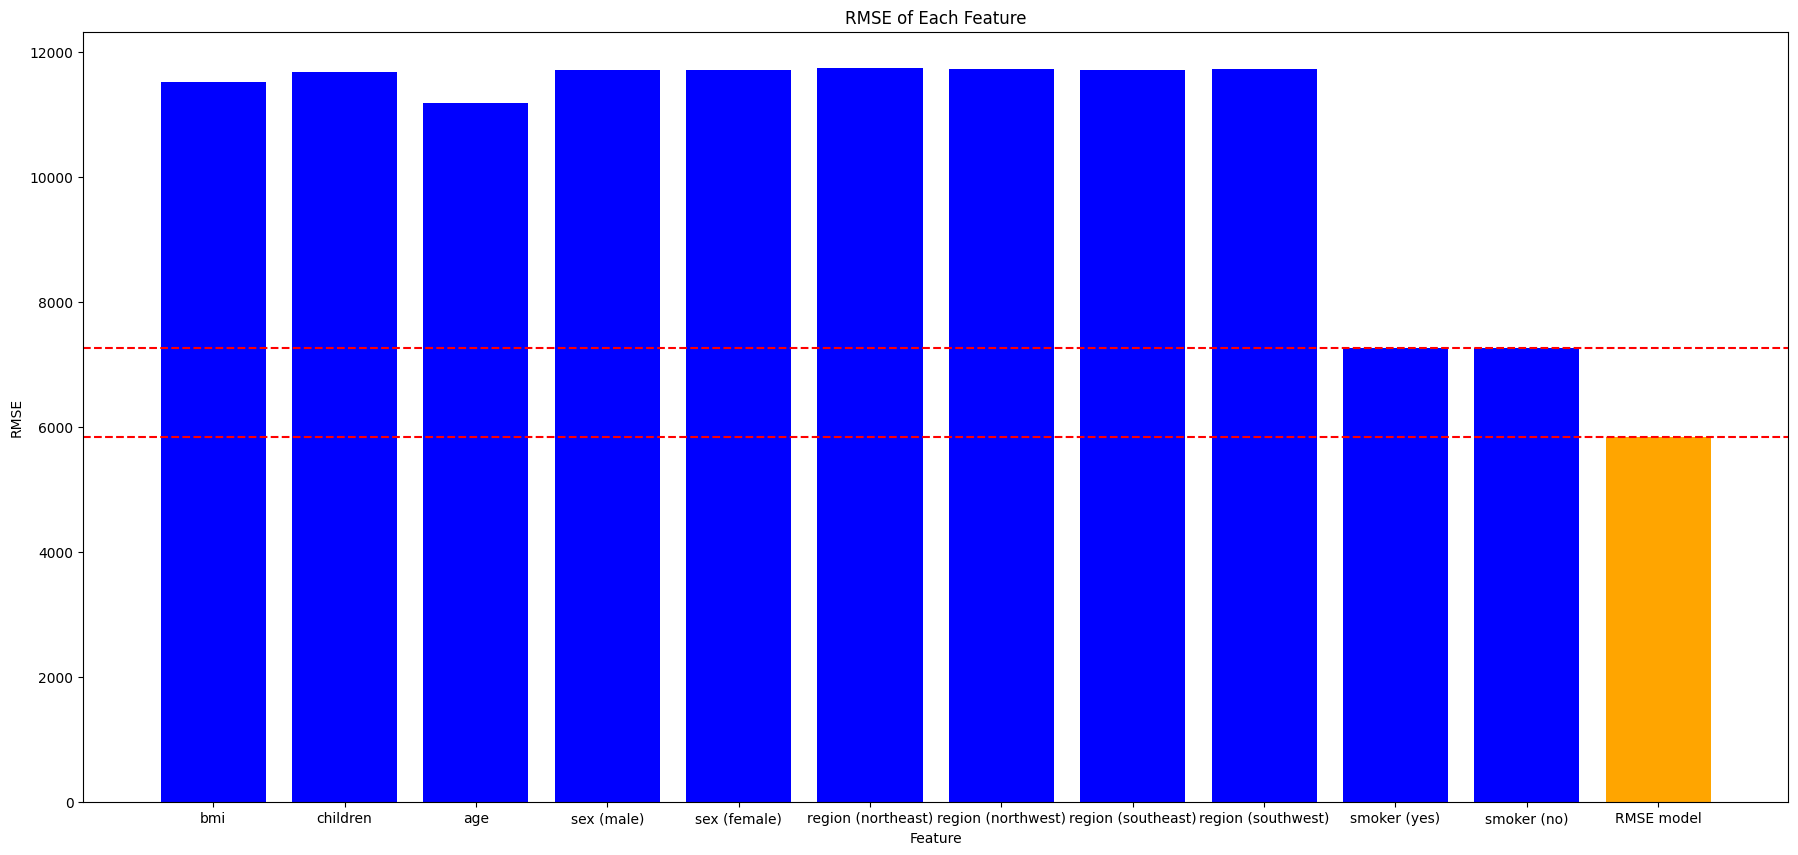

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the feature names and their corresponding RMSE values
feature_names = ['bmi', 'children', 'age', 'sex (male)', 'sex (female)', 'region (northeast)', 'region (northwest)', 'region (southeast)', 'region (southwest)', 'smoker (yes)', 'smoker (no)', 'RMSE model']
rmse_values = [rmse_calc(y, x_bmi, slope_bmi, intercept_bmi),
               rmse_calc(y, x_children, slope_children, intercept_children),
               rmse_calc(y, x_age, slope_age, intercept_age),
               rmse_calc(y, x_sex_male, slope_sex_male, intercept_sex_male),
               rmse_calc(y, x_sex_female, slope_sex_female, intercept_sex_female),
               rmse_calc(y, x_region_northeast, slope_region_northeast, intercept_region_northeast),
               rmse_calc(y, x_region_northwest, slope_region_northwest, intercept_region_northwest),
               rmse_calc(y, x_region_southeast, slope_region_southeast, intercept_region_southeast),
               rmse_calc(y, x_region_southwest, slope_region_southwest, intercept_region_southwest),
               rmse_calc(y, x_smoker_yes, slope_smoker_yes, intercept_smoker_yes),
               rmse_calc(y, x_smoker_no, slope_smoker_no, intercept_smoker_no),
               rmse]

# Set the figure size
plt.figure(figsize=(22, 10))

# Plot the RMSE values as bars
colors = ['blue'] * len(feature_names)
colors[-1] = 'orange'  # RMSE model color
plt.bar(feature_names, rmse_values, color=colors)


# Draw horizontal lines at the RMSE of the model and smoker (no)
plt.axhline(y=rmse, color='red', linestyle='--')  # RMSE model
plt.axhline(y=rmse_values[-2], color='red', linestyle='--')  # RMSE smoker (no)

# Set the labels and title
plt.xlabel('Feature')
plt.ylabel('RMSE')
plt.title('RMSE of Each Feature')

# Show the plot
plt.show()


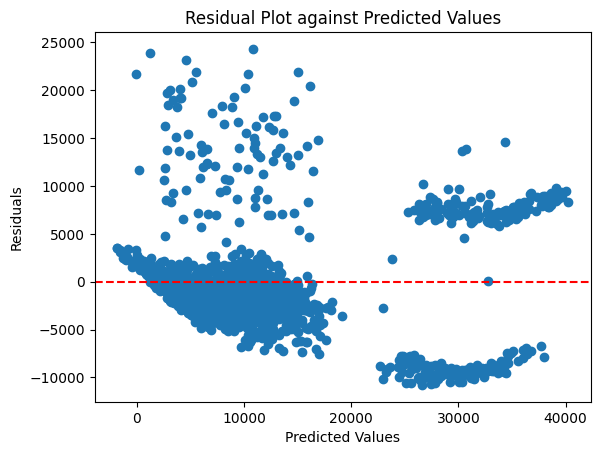

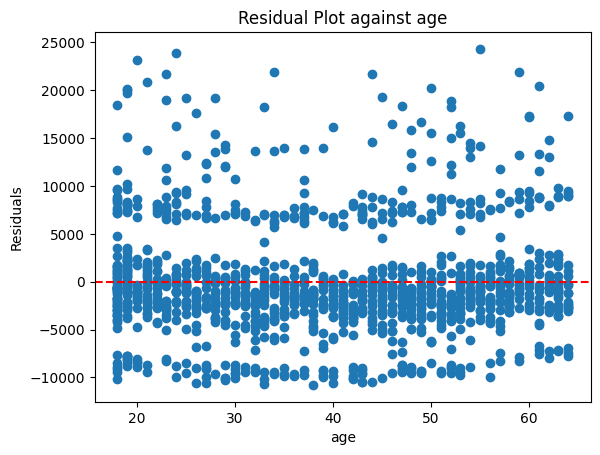

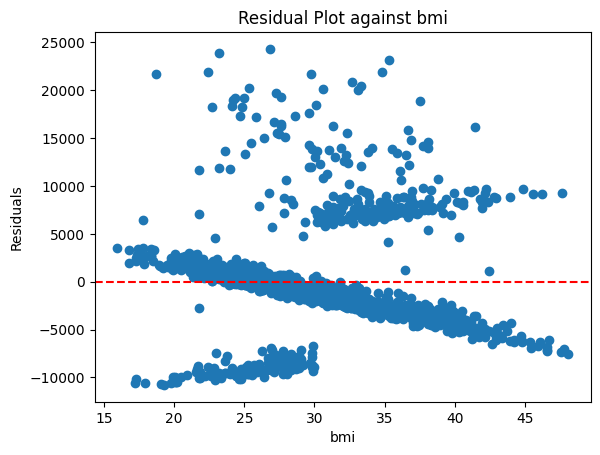

Breusch-Pagan Test - p-value: 3.153125328549213e-17


In [ ]:
# Calculate the predicted values
y_pred = model_multiple_regression.predict(X)

# Calculate the residuals
residuals = y - y_pred

# Residual plot against predicted values
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot against Predicted Values')
plt.show()

# Residual plot against 'age'
plt.scatter(X['age'], residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('age')
plt.ylabel('Residuals')
plt.title('Residual Plot against age')
plt.show()

# Residual plot against 'bmi'
plt.scatter(X['bmi'], residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('bmi')
plt.ylabel('Residuals')
plt.title('Residual Plot against bmi')
plt.show()

# Add a constant term to the predictor variables
X_with_constant = sm.add_constant(X)

# Breusch-Pagan test for homoscedasticity
_, p_value, _, _ = het_breuschpagan(residuals, X_with_constant)
print(f"Breusch-Pagan Test - p-value: {p_value}")


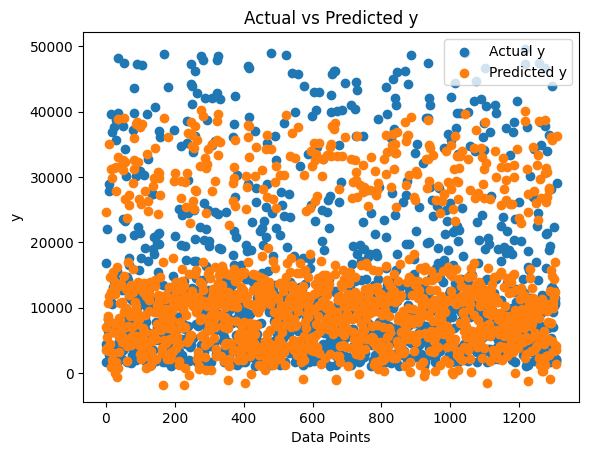

In [ ]:
import matplotlib.pyplot as plt

# Calculate the predicted y values
y_pred = model_multiple_regression.predict(X)

# Plot the actual y values and the predicted y values
plt.scatter(range(len(y)), y, label='Actual y')
plt.scatter(range(len(y)), y_pred, label='Predicted y')
plt.xlabel('Data Points')
plt.ylabel('y')
plt.title('Actual vs Predicted y')
plt.legend()
plt.show()


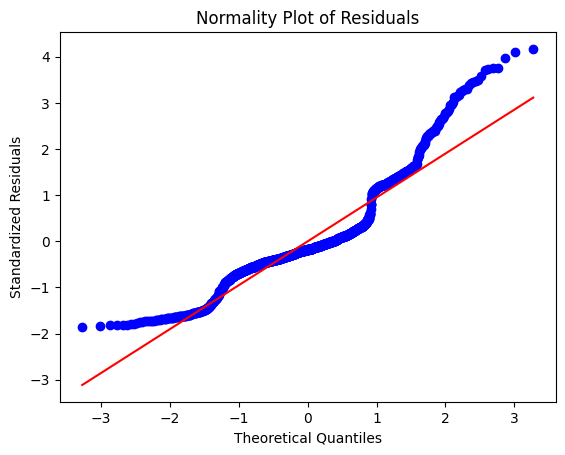

In [ ]:
import numpy as np
import scipy.stats as stats

# Calculate the residuals
residuals = y - y_pred

# Generate the normality plot
residuals_mean = np.mean(residuals)
residuals_std = np.std(residuals)
residuals_standardized = (residuals - residuals_mean) / residuals_std

# Plot the normality plot
stats.probplot(residuals_standardized, dist='norm', plot=plt)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Standardized Residuals')
plt.title('Normality Plot of Residuals')
plt.show()

